In [1]:
#Transfer Learning

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

In [4]:
conv_base = VGG16(weights = 'imagenet',include_top = False,input_shape = (150,150,3))

58900480/58889256 [==============================] - 48s 1us/step


In [18]:
#Can be Done using 2 Ways : 1. Feature Extraction: Using Model Conv Base with specific Classifier. This can be done in Two way 
                                #a. Computing labeled arrays and storing and then passing them in FC Classifier, feature extract,but can use Data Augmentation
                                #b. Including our classifier and then training the whole model with Conv Base trainable being False
                            # 2. Fine Tuning:

In [6]:
#Using Method 1 a.

In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [33]:
len(conv_base.trainable_weights)
out_put = []
for layer in conv_base.layers:
#     if layer=='block5_pool'
#         output_shape_layer = layer.output_shape()
    out_put.append(layer.output_shape)
last_layer_output = out_put[-1]
print(last_layer_output)

(None, 4, 4, 512)


In [10]:
conv_base.trainable = False

In [11]:
len(conv_base.trainable_weights)

0

In [12]:
import os

In [40]:
os.getcwd()
dataset = os.path.join(os.getcwd(),'small_dataset')
tr_dataset = os.path.join(dataset,'train')
test_dataset = os.path.join(dataset,'test')
val_dataset = os.path.join(dataset,'validation')


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
train_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=(1./255))

In [17]:
datagen = ImageDataGenerator(rescale=1./255)

In [88]:
batch_siz = 20

In [89]:

import numpy as np

In [95]:
def extract_features(directory,num_of_samples):
    features = np.zeros(shape = (num_of_samples,4,4,512))
    labels = np.zeros(shape = (num_of_samples))
    generator = datagen.flow_from_directory(directory,batch_size = batch_siz,class_mode = 'binary',target_size = (150,150))
    i = 0
    for inputs_batch,label_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_siz : (i + 1) * batch_siz] = features_batch
        labels[i*20:(i + 1)*20] = label_batch
        i+=1
        if i*batch_siz>=num_of_samples:
            break
    return features,labels

In [96]:
len(os.listdir(os.path.join(val_dataset,'dogs')))

500

In [97]:
tr_features,tr_label = extract_features(tr_dataset,2000)

Found 2000 images belonging to 2 classes.


In [98]:
test_feature,test_label = extract_features(test_dataset,1000)
val_feature,val_label = extract_features(val_dataset,1000)

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [101]:
tr_features.shape

(2000, 4, 4, 512)

In [102]:
#As we have to feed this into neural network we need to flatten it out to 1D

In [106]:
tr_features = np.reshape(tr_features,(2000,4*4*512))

In [107]:
tr_features.shape

(2000, 8192)

In [108]:
test_feature = np.reshape(test_feature,(1000,4*4*512))

In [109]:
val_feature = np.reshape(val_feature,(1000,4*4*512))

In [110]:
tr_label.shape

(2000,)

In [112]:
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential

In [116]:
network_3 = Sequential([
    Dense(256,activation = 'relu',input_dim=(4*4*512)),
    Dropout((0.5)),
    Dense(1,activation = 'sigmoid')
])
network_3.compile(loss= 'binary_crossentropy',optimizer = tf.keras.optimizers.RMSprop(learning_rate= 2e-5),metrics = ['accuracy'])

In [117]:
history = network_3.fit(tr_features,tr_label,epochs = 30,batch_size = 20,validation_data=(val_feature,val_label))

Epoch 1/30
100/100 [==============================] - 3s 28ms/step - loss: 0.6042 - accuracy: 0.6630 - val_loss: 0.4479 - val_accuracy: 0.8090
Epoch 2/30
100/100 [==============================] - 3s 26ms/step - loss: 0.4249 - accuracy: 0.7925 - val_loss: 0.3607 - val_accuracy: 0.8650
Epoch 3/30
100/100 [==============================] - 2s 25ms/step - loss: 0.3547 - accuracy: 0.8530 - val_loss: 0.3205 - val_accuracy: 0.8750
Epoch 4/30
100/100 [==============================] - 3s 26ms/step - loss: 0.3144 - accuracy: 0.8720 - val_loss: 0.2988 - val_accuracy: 0.8720
Epoch 5/30
100/100 [==============================] - 3s 28ms/step - loss: 0.2805 - accuracy: 0.8820 - val_loss: 0.2801 - val_accuracy: 0.8820
Epoch 6/30
100/100 [==============================] - 3s 28ms/step - loss: 0.2654 - accuracy: 0.8940 - val_loss: 0.2738 - val_accuracy: 0.8820
Epoch 7/30
100/100 [==============================] - 3s 28ms/step - loss: 0.2416 - accuracy: 0.8990 - val_loss: 0.2602 - val_accuracy: 0.8900

In [118]:
history_dict = history.history

In [120]:
epochs = range(1,len(history_dict['accuracy'])+1)

In [122]:
acc= history_dict['accuracy']
loss= history_dict['loss']
val_acc= history_dict['val_accuracy']
val_loss= history_dict['val_loss']

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline

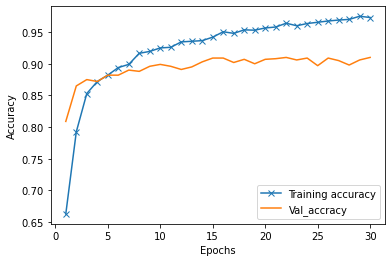

In [126]:
plt.plot(epochs,acc,label = 'Training accuracy',marker = 'x')
plt.plot(epochs,val_acc,label = 'Val_accracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

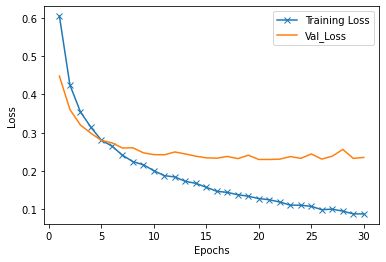

In [127]:
plt.plot(epochs,loss,label = 'Training Loss',marker = 'x')
plt.plot(epochs,val_loss,label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [128]:
#It is still overfitting despite using DropoOut, because the main thing which can reduce overfitting is Data Augmentation,but it
# cant be done with this method, for that we need to train the whole network by adding our own Classifier and usign 
#Image Data Generator

In [129]:
network_3.evaluate(test_feature,test_label)

32/32 [==============================] - 0s 5ms/step - loss: 0.2605 - accuracy: 0.8830


[0.2604633569717407, 0.8830000162124634]

In [132]:
conv_base.save('Conv_Base_from_VGG16.h5')

In [133]:
network_3.save('Top_Dense_Layer_specifically_made.h5')

In [143]:
#Now we can go for Part second method of Feature Extraction: which is making the whole model and Training it
from tensorflow.keras.layers import Flatten
import tensorflow
conv_base.trainable = False

In [141]:
network_3_b = Sequential([
    conv_base,
    Flatten(),
    Dense(256,activation = 'relu'),
    Dense(1,activation = 'sigmoid')
])

In [154]:
network_3_b.compile(loss= 'binary_crossentropy',optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate= 2e-5),metrics=['accuracy'])

In [146]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [149]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')


In [150]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [151]:
train_dataset = train_datagen.flow_from_directory(tr_dataset,target_size = (150,150),batch_size= 20,class_mode = 'binary')

Found 2000 images belonging to 2 classes.


In [153]:
validation_dataset = test_datagen.flow_from_directory(test_dataset,target_size = (150,150),batch_size= 20,class_mode = 'binary')

Found 1000 images belonging to 2 classes.


In [156]:
network_3_b.fit(train_dataset,steps_per_epoch=20,epochs=30,validation_data=validation_dataset,validation_steps=20)

Epoch 1/30
20/20 [==============================] - 165s 9s/step - loss: 0.6257 - accuracy: 0.6575 - val_loss: 0.5667 - val_accuracy: 0.7640
Epoch 2/30
20/20 [==============================] - 170s 9s/step - loss: 0.6017 - accuracy: 0.6950 - val_loss: 0.5240 - val_accuracy: 0.7920
Epoch 3/30
20/20 [==============================] - 172s 9s/step - loss: 0.5559 - accuracy: 0.7600 - val_loss: 0.4850 - val_accuracy: 0.8140
Epoch 4/30
20/20 [==============================] - 164s 9s/step - loss: 0.5237 - accuracy: 0.7800 - val_loss: 0.4648 - val_accuracy: 0.8100
Epoch 5/30
20/20 [==============================] - 160s 8s/step - loss: 0.4863 - accuracy: 0.8175 - val_loss: 0.4486 - val_accuracy: 0.8100
Epoch 6/30
20/20 [==============================] - 161s 8s/step - loss: 0.5097 - accuracy: 0.7450 - val_loss: 0.4086 - val_accuracy: 0.8370
Epoch 7/30
20/20 [==============================] - 162s 8s/step - loss: 0.4884 - accuracy: 0.7850 - val_loss: 0.3932 - val_accuracy: 0.8420
Epoch 8/30
20

In [157]:
# if it would have been trained much longer it would have easily achieved 90+ accuracy

In [162]:
history = id(0x20b81b9c700)

In [163]:
history

2248444514704

In [164]:
test_dataset1 = test_datagen.flow_from_directory(val_dataset,target_size = (150,150),batch_size= 20,class_mode = 'binary')

Found 1000 images belonging to 2 classes.


In [165]:
network_3_b.evaluate(test_dataset1)

50/50 [==============================] - 114s 2s/step - loss: 0.2793 - accuracy: 0.8820


[0.2792971432209015, 0.8820000290870667]

In [166]:
network_3.save('Most_accurate_model.h5')

In [167]:
# it can be easily seen that we have achieved 88 percent accuracy on training data, 87 on val and 84 on training data. If during
#training time we had more epochs, this would have easily reached 95+